# SIS

Compartmental models consider an initial population of susceptible individuals where an infectious agent has been introduced and simulate the dynamics of a disease by studying the susceptible individuals that become infected over time. They assume that the population is divided into subsets of individuals or compartments with epidemiological characteristics. These models are deterministic, so that the initial parameters are fixed and consequently, the model predictions are determined by these initial conditions. 

There are various compartmental model structures, however, the available data limit the study to a specific type of model: the SIR (Susceptible-Infected-Removed) model. Let $S(t)$ be the compartment formed by the susceptible individuals at time $t$, $I(t)$ the compartment constituted by those individuals infected (assuming that every infected individual is infectious, i.e. capable of transmitting the infection) at time $t$ and $R(t)$ the compartment composed of the number of individuals who at time $t$ do not contribute to the spread of the infection, either by immunization (via vaccination or recovery from the disease by acquiring natural immunity against reinfection) or by death. 

Transitions of individuals between compartments are described by the following system of differential equations:

\begin{align}
    & \frac{dS}{dt} = -\beta S \frac{I}{N}, \\
    & \frac{dI}{dt} = \beta S \frac{I}{N} - \gamma I, \\
    & \frac{dR}{dt} = \gamma I,
\end{align}

where $N(t) = S(t) + I(t) + R(t)$ and the constants $\beta$ and $\gamma$ are detailed below.

The above model is based on the following assumptions and simplifications:

- The total population $N(t)$ is closed, that is, no natural births and deaths are considered. Therefore, $N(t)$ is constant and $dS/dt+dI/dt+dR/dt=0$.
- Homogeneous contact or assume that contacts between susceptible and infectious individuals occur randomly. The probability that a susceptible individual has contact with an infectious individual is $I/N$. The constant $\beta(N)$ is the contagion rate (probability that a susceptible becomes infected having been in contact with an infectious), which depends on the population. The term $\beta(N) S I/N$ is the incidence or new infected cases per unit time.  
- The rate of recovery from infection and death per capita $\gamma$ is constant. This implies that the time an individual remains infected has exponential distribution of mean $1/\gamma $. 

Note that these hypotheses do not hold for this case: total population is neither constant nor closed (mobility is allowed in Spain since the end of the state of alarm); COVID-19 spread is not homogeneous but heterogeneous since a small fraction of the total population is responsible for most infections [(Szapudi, Istvan (2020). Heterogeneity in SIR epidemics modeling: superspreaders and herd immunity.)](https://sci-hub.hkvisa.net/10.1007/s41109-020-00336-5) and there are several clusters of superspreading such as care facilities, restaurants and bars, workplaces, music events, etc [(Furuse, Y., Sando, E., Tsuchiya, N., Miyahara, R., Yasuda, I., Ko, Y. K....Oshitani, H. (2020). Clusters of Coronavirus Disease in Communities)](https://sci-hub.hkvisa.net/10.3201/eid2609.202272).

Despite these simplifications, this model has proven useful in epidemic modeling. The objective of this analysis is to test the ability of the SIR model to capture the patterns in the series, even if it departs from the starting assumptions.

## Setup

In [1]:
# data handling
import pandas as pd
import numpy as np

# visualizations
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import plotly.io as pio
pio.templates.default = "plotly_white"

# for compartmental models
import comod
from comod.models import sir  # Standard SIR model
from numpy.lib.stride_tricks import sliding_window_view

# model performance analysis
from utils import metrics, plot_acf_pacf, load_last_final_data, plot_multistep, plot_params
from sktime.performance_metrics.forecasting import geometric_mean_relative_absolute_error
import scipy.stats as st

# path handling
from pathlib import Path

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# seed to replicate results 
np.random.seed(123)

ModuleNotFoundError: No module named 'sktime'

# Data

Read saved static data (csv file) of COVID-19 cases in Spain. More info in https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos. These data have been previously processed to add the total Spanish population (assumed constant) and recovered cases. Due to the lack of data, an infected person is considered to have recovered 14 days after the case was reported. This may be a rough estimate, but it makes sense as it coincides with quarantine periods imposed by the government.

In [2]:
# read processed data
df = load_last_final_data(from_folder='final')
# show first observations
df.head()

,Population,Infected,Deaths,Recovered
Date,,,,
2020-03-02,46796540,26.0,0.0,0.0
2020-03-03,46796540,38.0,0.0,0.0
2020-03-04,46796540,51.0,0.0,0.0
2020-03-05,46796540,75.0,0.0,0.0
2020-03-06,46796540,110.0,1.0,1.0


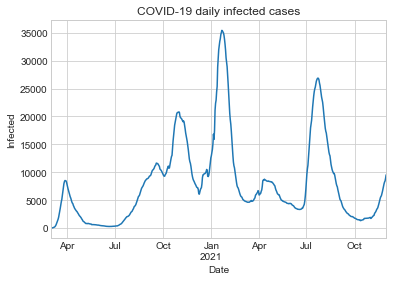

In [3]:
# plot infected curve
df['Infected'].plot()
plt.title('COVID-19 daily infected cases')
plt.ylabel('Infected')
plt.xlabel('Date')
plt.show()

## Prepare data 

Before further analysis, data must be prepared to fit the model implementation:
- Population is saved as constant in POPULATION variable. 
- Only variables needed for the analysis are kept: susceptible, infected and recovered cases. 
- Transform dates to integer timesteps to prevent unexpected errors when handling datetime types. 
- Transform data from DataFrame to arrays S, I, R to speed up computations. 

In [4]:
# constant population
POPULATION = df['Population'].mean()

df2 = df[['Infected']]

In [5]:
# Confirmed, Deaths, Recovered and Active cases to SIR form
def CDRA_to_SIS(df, population):
    df2 = df[[]].copy()
    df2["S"] = 0  # Just to produce the desired order
    df2["I"] = df[["Infected"]]
    df2["S"] = population - df2["I"]
    return df2

In [6]:
# transform data
df3 = CDRA_to_SIS(df2, POPULATION)

In [7]:
# use day count instead of datetime
t = np.linspace(0, len(df3)-1, len(df3))

# S, I, R to array
S = df3['S'].values
I = df3['I'].values


After completing the data preparation phase, the number of susceptibles over time is plotted to visually check if it has been well transformed.

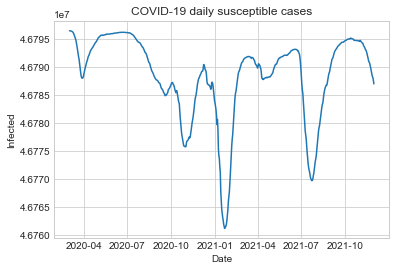

In [8]:
# plot all avaible data of susceptible cases
plt.plot(df3.index, df3['S'])
plt.title('COVID-19 daily susceptible cases')
plt.ylabel('Infected')
plt.xlabel('Date')
plt.show()

# # or plot a subset 
# sns.lineplot(df3.index[50:200], df3['S'][50:200])
# plt.show()

**Interpretation of the graph**

The graph shows how at the beginning of the pandemic the entire population is susceptible. As infections increase, many susceptible people become infected and the number of susceptible people decreases.

# SIR modeling

To fit the SIR model, the package comod is used (doc: https://comod.readthedocs.io/en/latest/). 

It is not adequate to fit a single SIR model to all available data: SIR model is deterministic, so given an initial state, the solution is uniquely determined by it. This approach is unrealistic since the number of infected people changes over time depending on the measures applied, and therefore the parameters change as well. For example, setting the infection rate at the beginning of the series is equivalent to assuming that during the quarantine, this infection rate was exactly the same which is not possible because contacts were reduced.
Therefore, small time windows need to be considered to fit a SIR model on each: the initial values of $S, I, R$ in each window will determine the predictions.

## Methodology

The procedure is as follows:
1. Choose the number of time steps in the past over which to adjust a SIR model (window_size) and the number of time steps in the future to get forecasts (steps_ahead).
2. The series consisting of the S, I, R compartments is taken and divided into successive train-test windows of fixed sizes "window_size" and "steps_ahead". This is:

#TODO: add photo of the successive windows scheme

3. Take the values of S, I, R from each train window and estimate the parameters $\beta$ and $\gamma$. Then, given the initial state of the compartiments for the given window $(S_0, I_0, R_0)$ the system of differential equations is solved and therefore values of $S, I, R$ for a given $t$ are generated; forecasts are obtained by setting as initial state the last known value of train window $(S_{window\_size-1}, I_{window\_size-1}, R_{window\_size-1})$ and solving the corresponding system. 
4. Once a SIR model is fit for the train window given, it is used to predict the "steps_ahead" next steps of time.
5. Predictions are compared to the corresponding test window (made of "steps_ahead" time steps consecutive to the train window) to evaluate the goodness of the fit. 
6. Repeat this for all data available.

For ease of analysis, the class WindowFit is defined. Given all data, the class generates the necessary windows, plots and evaluates the predictions. Two forms of evaluations are allowed: multiple train-test splits and walk-forward validation (recommended). This should be specified by the eval_mode parameter, which is 'WF' by default. The metrics considered to evaluate performance are defined in the variable metrics. 

For sake of comparison, a baseline or benchmark to beat has been defined. The baseline is taken by predicting for time t+1 the value of t, i.e., repeating the last value. This is a very trivial approximation, therefore a model will be considered useful or relevant if it is able to overcome it.

**Notes:**
- The function plot_windows(max_subplots) displays max_subplots plots made of a random train window followed by the corresponding test window, the forecasts and the baseline. Note that the purpose of this function is merely illustrative and the order of the series is always preserved as it is mandatory in any time series analysis.

In [167]:
class WindowFit:
    
    def __init__(self, data, window_size=22, steps_ahead=14, metrics=metrics, eval_mode='WF'):
        # parameters
        self.window_size = window_size
        self.steps_ahead = steps_ahead

        # store raw data
        self.data = np.array(data)
        self.train, self.test = self.train_test_split(self.data, eval_mode)
        self.baseline = self.get_baseline(self.train)

        # parameters
        self.beta_series = []
        self.gamma_series = []

        # metrics to evaluate
        self.metrics = metrics


    def train_test_split(self, data, eval_mode):
        """
        Split data into train and test subsets
        Args:
            data (pd.DataFrame or np.array): Data to be split
            eval_mode (str): Mode of evaluation, 'WF' for Walk Forward evaluation, 'MTTS' for Multiple Train Test Splits 
        Returns:
            train (numpy.ndarray): Train data
            test (numpy.ndarray): Test data
        """
        train, test = [], []

        if eval_mode == 'WF':
            # walk forward evaluation
            for compartiment in data:
                train.append(sliding_window_view(compartiment[:-(self.steps_ahead)], window_shape=self.window_size))
                test.append(sliding_window_view(compartiment[self.window_size:], window_shape=self.steps_ahead))

        elif eval_mode == 'MTTS':
            n_windows = data.shape[1]//(self.window_size+self.steps_ahead) # perfect windows 
            data_start_point = data.shape[1]%(self.window_size+self.steps_ahead) # data start to generate perfect windows sizes
            
            for compartiment in data:
                window = np.array(np.split(compartiment[data_start_point:], n_windows))
                train.append(window[:, :-self.steps_ahead])
                test.append(window[:, -self.steps_ahead:])
        else:
            raise ValueError('Evaluation mode not recognized')

        return np.array(train), np.array(test)

    def get_baseline(self, train):
        baselines = []
        for compartiment in train:
            baseline = []
            for window in compartiment:
                baseline.append(np.repeat(window[-1], self.steps_ahead))           
            baselines.append(np.array(baseline))
        return np.array(baselines)

    def fit_predict(self, window, return_only_predictions=False):
        """
        Fit the model to a window and predict the future

        Args:
            window (numpy.ndarray): a window with [S, I, R] data to fit SIR model and predict future

        Returns:
            predictions (numpy.ndarray): a window with [S, I, R] data predicted from the fitted SIR model

        """
        # define a SIR model
        model = comod.Model("SI",
            ["beta", "gamma"],
            [
                ("S", "I", "beta I / N"),
                ("I", "S", "gamma")
            ],
            # Special state names can be set with the following options:
            # Total population. Can be used in the coefficients, but not as origin/destination.
            sum_state="N", 
            # The nothingness (?) from which one is born and to which one dies.
            nihil_state="!",  # Can be used as origin/destination, but not in the cofficients.
        )
        
        # define time mesh
        t_window = np.arange(self.window_size) # time mesh for the window with step_size>window_size
        
        # get best-fit parameters
        fit_pars = model.best_fit(
            np.asarray(window), t_window, [0.1, 1/14], # Existing data  # Time mesh  # Initial guess
            ls_kwargs={'bounds':(0, np.inf)}  
        ).x

        # get fitted parameters
        fit_beta, fit_gamma = fit_pars
        self.beta_series.append(fit_beta)
        self.gamma_series.append(fit_gamma)

        # initial states:
        S0_train, I0_train = window[0][0], window[1][0]
        S0_pred, I0_pred= window[0][-1], window[1][-1]

        # solve the model numerically
        S_simulated, I_simulated = model.solve(
            (S0_train, I0_train),  # Initial state
            [fit_beta, fit_gamma],  # Coefficient values
            t=np.arange(self.window_size),  # Time mesh
            method="RK45",  # see scipy.integrate.solve_ivp
        )

        # solve the model numerically
        S_pred, I_pred = model.solve(
            (S0_pred, I0_pred),  # Initial state
            [fit_beta, fit_gamma],  # Coefficient values
            t=np.arange(self.window_size, self.window_size+self.steps_ahead),  # Time mesh
            method="RK45",  # see scipy.integrate.solve_ivp
        )

        if return_only_predictions is True:
            return S_pred, I_pred
        else:
            return np.append(S_simulated, S_pred), np.append(I_simulated, I_pred)
        
    def random_windows(self, return_baseline=False):
        """
        Generate random windows
        """
        random_index = np.random.randint(0, self.train.shape[1])
        random_window_train, random_window_test = self.train[:, random_index], self.test[:, random_index]
        if return_baseline is True:
            random_window_baseline = self.baseline[:, random_index]
            return random_window_train, random_window_test, random_window_baseline[1]
        else:
            return random_window_train, random_window_test

    def plot_windows(self, max_subplots=3):
        """
        Plot real infected data, the predictions and the baseline to compare
        Args:
            max_subplots (int): maximum number of subplots to plot
        """
        example_windows = [self.random_windows(return_baseline=True) for _ in range(max_subplots)]

        for train_window, test_window, baseline_window in example_windows:
            t_window = np.arange(self.window_size+self.steps_ahead)

            _, I_simulated = self.fit_predict(train_window, return_only_predictions=False)

            plt.figure(figsize=(8, 5))
            plt.scatter(t_window[:self.window_size], train_window[1], color='dodgerblue', label='I real')
            plt.plot(t_window[:self.window_size], I_simulated[:self.window_size], color='orange', label='I simulated', marker='o')
            plt.plot(t_window[-self.steps_ahead:], I_simulated[-self.steps_ahead:], color='darkorange', label='I predicted', marker='o')
            plt.scatter(t_window[-self.steps_ahead:], test_window[1], color='blue', label='I test')
            plt.plot(t_window[-self.steps_ahead:], baseline_window,  marker='o', color='silver', label='I baseline')

            plt.ylabel('Infected')
            plt.xlabel('Time steps')
            plt.legend()
            plt.show()

    def get_all_predictions(self, horizon):
        """
        Get all predictions in a single array for a time horizon of 'horizon'

        Args:
            horizon (int): time horizon to predict
        """
        predictions = []
        for i in range(0, self.train.shape[1]):
            window = self.train[:, i]
            _, I_pred = self.fit_predict(window, return_only_predictions=True)
            predictions.append(I_pred[(horizon-1)])
            print('train_window: ', i)
        return np.array(predictions)

    def get_predictions_df(self, horizon=None, subset=None):
        if horizon is None:
            horizon = self.steps_ahead        
        y_pred = []
        for i in range(self.train.shape[1]):
            window_train = self.train[:, i]
            _, I_simulated = self.fit_predict(window_train, return_only_predictions=True)
            y_pred.append(I_simulated)

        y_fit = pd.DataFrame(y_pred, columns=[f'y_step_{i}' for i in range(1,horizon+1)])
        if subset == 'train':
            y_fit['Date'] = df[:len(self.data[1])]['Infected'].index[self.window_size:(len(y_fit)+self.window_size)]
        elif subset == 'test':
            y_fit['Date'] = df[-len(self.data[1]):]['Infected'].index[self.window_size:(len(y_fit)+self.window_size)]
        else:
            y_fit['Date'] = np.arange(0, len(self.data))
        y_fit.set_index(['Date'], inplace=True)
        return y_fit

    def get_residuals(self, horizon):
        """
        Get the residuals (residuals = expected_value-forecast_value) for a time horizon of 'horizon'
        """
        I_pred_total = self.get_all_predictions(horizon)
        I_true = self.test[:, horizon-1][1]
        return I_true - I_pred_total # forecast errors

    def evaluate(self):
        """
        Evaluate the performance of the model
        """
        evaluation = {}

        # evaluate per timesteps
        for i in range(0, self.steps_ahead):
            sir_step_evaluation, baseline_step_evaluation = {}, {}

            test_step = self.test[1][:, i] 
            print('step:', i+1)
            predicted_step = self.get_all_predictions(horizon=i+1)
            baseline_step = self.baseline[1][:, i]

            # evaluate
            for metric_name, metric in self.metrics.items():
                try:
                    sir_step_evaluation[metric_name] = metric(test_step, predicted_step)
                    baseline_step_evaluation[metric_name] = metric(test_step, baseline_step)
                except:
                    sir_step_evaluation[metric_name] = np.nan
                    baseline_step_evaluation[metric_name] = np.nan

                # sir_step_evaluation['GMRAE'] = geometric_mean_relative_absolute_error(test_step, predicted_step, y_pred_benchmark=baseline_step)
                evaluation[f'step_{i+1}'] = sir_step_evaluation
                evaluation[f'baseline_step_{i+1}'] = baseline_step_evaluation

        return evaluation

## Fit

An example of how to use the previous class to adjust a model to successive windows of size window_size=7 (7 time steps) to predict the next steps_ahead=3 (3 time steps) is shown below. That is, predict the infected cases for the next 3 days knowing the infected cases values of the previous 7 days. 

In [168]:
# create an object of the class
w = WindowFit(window_size=7, steps_ahead=3, data=[S, I], eval_mode='WF')
# get a random train and test window
window_train, window_test = w.random_windows()
# fit the model and get the predictions
S_simulated, I_simulated= w.fit_predict(window_train, return_only_predictions=True)
# print the predictions of infected individuals for the random window 
print(f'I predicted: {I_simulated}') 

I predicted: [25791.         24799.97796653 23847.03609362]


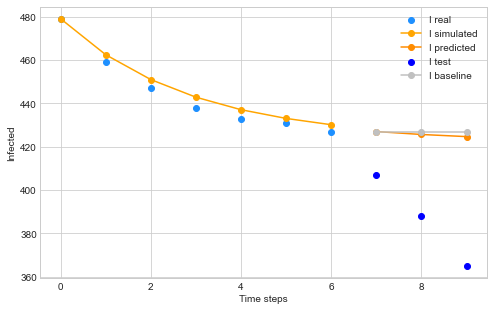

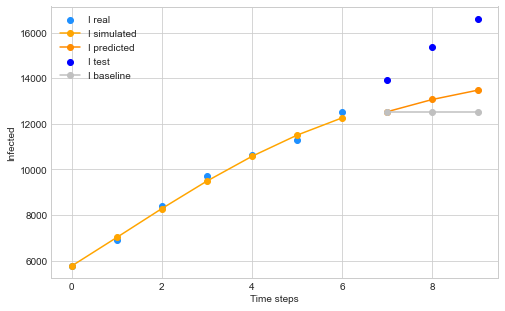

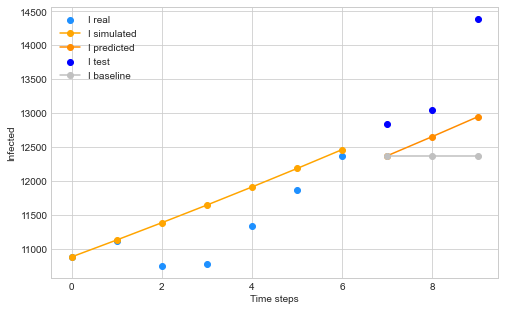

In [169]:
# fit model and plot the results for 3 random windows
w.plot_windows(max_subplots=3)

## Evaluation

To make this type of model comparable to other types of models, only the last 30% of the series is considered for evaluation. To be consistent with classical machine learning nomenclature, this subset is called test_data since it is used to evaluation. Note that this subset is not the same as the test windows defined above.

The subset called train_data will be used later to get the best window_size.


In [170]:
# define test size as the 30% of total data points
test_size = int(0.3*len(df))
train_data = [S[:-test_size], I[:-test_size]]
test_data = [S[-test_size:], I[-test_size:]]

Below is shown how to perform the evaluation using windows of 20 past points to forecast up to 14 days in the future. Different metrics are used to determine the quality of the predictions at each time step. 

In [171]:
# evaluate the model
w_eval = WindowFit(window_size=22, steps_ahead=14, data=test_data, eval_mode='WF')
e = w_eval.evaluate()
# show the evaluation as DataFrame
pd.DataFrame(e).style.highlight_min(axis=1)

step: 1
train_window:  0
train_window:  1
train_window:  2
train_window:  3
train_window:  4
train_window:  5
train_window:  6
train_window:  7
train_window:  8
train_window:  9
train_window:  10
train_window:  11
train_window:  12
train_window:  13
train_window:  14
train_window:  15
train_window:  16
train_window:  17
train_window:  18
train_window:  19
train_window:  20
train_window:  21
train_window:  22
train_window:  23
train_window:  24
train_window:  25
train_window:  26
train_window:  27
train_window:  28
train_window:  29
train_window:  30
train_window:  31
train_window:  32
train_window:  33
train_window:  34
train_window:  35
train_window:  36
train_window:  37
train_window:  38
train_window:  39
train_window:  40
train_window:  41
train_window:  42
train_window:  43
train_window:  44
train_window:  45
train_window:  46
train_window:  47
train_window:  48
train_window:  49
train_window:  50
train_window:  51
train_window:  52
train_window:  53
train_window:  54
train_window

,step_1,baseline_step_1,step_2,baseline_step_2,step_3,baseline_step_3,step_4,baseline_step_4,step_5,baseline_step_5,step_6,baseline_step_6,step_7,baseline_step_7,step_8,baseline_step_8,step_9,baseline_step_9,step_10,baseline_step_10,step_11,baseline_step_11,step_12,baseline_step_12,step_13,baseline_step_13,step_14,baseline_step_14
RMSLE,0.054830,0.054830,0.084277,0.105147,0.117091,0.154518,0.151817,0.203218,0.187758,0.251128,0.224805,0.298731,0.263295,0.346258,0.302498,0.393259,0.342731,0.439927,0.383352,0.486030,0.424505,0.531421,0.466023,0.575971,0.507771,0.619877,0.549880,0.663212
MAE,339.179487,339.179487,493.081752,676.211538,665.332206,1014.352564,856.559432,1350.173077,1057.830972,1686.602564,1277.690744,2022.461538,1518.164927,2356.826923,1808.308452,2691.557692,2128.243774,3025.551282,2465.884783,3357.442308,2832.963447,3687.333333,3224.327436,4016.403846,3646.176847,4341.044872,4095.985300,4663.724359
RMSE,501.402686,501.402686,753.329381,988.340564,1059.106853,1466.329053,1392.498308,1938.336167,1747.202635,2404.358401,2124.869401,2865.628273,2538.696056,3323.660871,2999.217781,3778.446381,3507.715362,4227.399639,4063.653132,4668.194919,4675.697217,5099.785921,5351.357609,5521.268605,6101.048225,5933.829358,6938.771963,6338.269174
MAPE,0.041690,0.041690,0.061059,0.081333,0.080973,0.119999,0.101361,0.157946,0.122254,0.195846,0.144593,0.234214,0.167722,0.272914,0.193941,0.312009,0.221834,0.351552,0.249344,0.391384,0.277561,0.431688,0.306693,0.472351,0.337724,0.513261,0.369818,0.554652


It should be noted that the lower the error, the better the forecast. In this analysis the point of interest is the 14-day forecast. Naturally, the further away the horizon to be predicted, the greater the uncertainty and therefore the greater the error.

## Estimation of best window size

The code below evaluates the results for different window sizes and the table highlights the best ones (lower ones) for 14 steps ahead. The train_data subset defined above will be used for this purpose.

In [14]:
eval_window_size = {}

for window_size in range(2, 60):
    print(f'Evaluating SIR for window size {window_size}...')
    w = WindowFit(data=train_data, window_size=window_size, steps_ahead=14, eval_mode='WF')
    evaluation_metrics = w.evaluate()
    
    window_error = evaluation_metrics['step_14']

    eval_window_size[f'window_size_{window_size}'] = window_error

Evaluating SIR for window size 2...
Evaluating SIR for window size 3...
Evaluating SIR for window size 4...
Evaluating SIR for window size 5...
Evaluating SIR for window size 6...
Evaluating SIR for window size 7...
Evaluating SIR for window size 8...
Evaluating SIR for window size 9...
Evaluating SIR for window size 10...
Evaluating SIR for window size 11...
Evaluating SIR for window size 12...
Evaluating SIR for window size 13...
Evaluating SIR for window size 14...
Evaluating SIR for window size 15...
Evaluating SIR for window size 16...
Evaluating SIR for window size 17...
Evaluating SIR for window size 18...
Evaluating SIR for window size 19...
Evaluating SIR for window size 20...
Evaluating SIR for window size 21...
Evaluating SIR for window size 22...
Evaluating SIR for window size 23...
Evaluating SIR for window size 24...
Evaluating SIR for window size 25...
Evaluating SIR for window size 26...
Evaluating SIR for window size 27...
Evaluating SIR for window size 28...
Evaluatin

In [15]:
# show the evaluations highlighting the best metrics
pd.DataFrame(eval_window_size).style.highlight_min(axis=1)

,window_size_2,window_size_3,window_size_4,window_size_5,window_size_6,window_size_7,window_size_8,window_size_9,window_size_10,window_size_11,window_size_12,window_size_13,window_size_14,window_size_15,window_size_16,window_size_17,window_size_18,window_size_19,window_size_20,window_size_21,window_size_22,window_size_23,window_size_24,window_size_25,window_size_26,window_size_27,window_size_28,window_size_29,window_size_30,window_size_31,window_size_32,window_size_33,window_size_34,window_size_35,window_size_36,window_size_37,window_size_38,window_size_39,window_size_40,window_size_41,window_size_42,window_size_43,window_size_44,window_size_45,window_size_46,window_size_47,window_size_48,window_size_49,window_size_50,window_size_51,window_size_52,window_size_53,window_size_54,window_size_55,window_size_56,window_size_57,window_size_58,window_size_59
RMSLE,0.647734,0.624459,0.619700,0.619260,0.617535,0.620958,0.626467,0.627377,0.620211,0.610230,0.599630,0.592118,0.591367,0.593311,0.594877,0.594406,0.593749,0.592406,0.590674,0.589967,0.590657,0.590175,0.588645,0.586521,0.584485,0.583225,0.582860,0.583642,0.584682,0.586397,0.588667,0.591350,0.594160,0.596994,0.599693,0.602421,0.605037,0.607443,0.609691,0.611745,0.613559,0.615111,0.616579,0.617813,0.618847,0.619613,0.619805,0.619677,0.619446,0.618936,0.618128,0.617074,0.615915,0.615058,0.614317,0.613634,0.613387,0.613255
GMRAE,0.755147,0.745785,0.739912,0.782168,0.793595,0.798651,0.834108,0.851257,0.852217,0.830185,0.831741,0.803263,0.813625,0.838641,0.864092,0.909801,0.922443,0.975781,1.000454,1.005192,1.009885,1.009397,1.032300,1.029563,1.049016,1.065869,1.083951,1.098792,1.096431,1.113343,1.127225,1.156567,1.164854,1.164875,1.177253,1.198130,1.200540,1.225144,1.240343,1.244384,1.246446,1.235255,1.250180,1.229330,1.232131,1.216921,1.202349,1.192191,1.191325,1.184520,1.179529,1.176142,1.153382,1.140356,1.145826,1.127650,1.112394,1.111977
MAE,6610.007067,6278.277414,6126.172421,6178.136576,6248.337413,6382.175012,6508.018182,6539.396240,6382.862646,6119.582579,5828.492052,5615.449476,5562.154935,5560.930481,5541.789409,5489.150944,5439.801152,5379.089234,5315.162128,5266.143290,5235.768378,5193.630360,5143.010924,5088.602922,5045.037980,5015.720909,4997.492535,4991.203569,4990.551668,4996.699972,5007.357483,5017.198382,5025.785742,5035.724075,5045.212552,5054.922728,5063.592572,5070.803145,5077.322993,5082.834252,5087.120886,5091.548960,5096.347384,5098.656452,5098.747721,5095.040964,5091.502472,5085.875771,5081.749572,5074.506600,5065.838783,5055.647433,5041.622465,5027.242973,5012.720491,4995.296187,4976.856896,4960.750621
RMSE,22691.746953,18983.410977,17618.395873,17198.529939,17092.876800,17260.431513,17484.644987,17554.164755,16838.982537,15205.843319,13083.233392,11660.867059,11386.623889,11301.874401,11175.411173,10908.850643,10672.996178,10398.024026,10116.880122,9915.809175,9793.460157,9638.581437,9456.439278,9260.315390,9094.568683,8978.393909,8900.041642,8851.151194,8818.860528,8806.777882,8807.969216,8813.605665,8820.989104,8830.920722,8842.466503,8854.531565,8863.199001,8868.954108,8873.118456,8876.470954,8879.091043,8880.547106,8880.356579,8878.011786,8873.073116,8865.430946,8855.141008,8842.079347,8825.251414,8803.216015,8775.679229,8743.280937,8707.490465,8668.476885,8625.095968,8576.671715,8523.439148,8466.305523
MAPE,0.752240,0.724500,0.719659,0.723450,0.722881,0.731374,0.742444,0.743304,0.717970,0.681761,0.645902,0.622063,0.617238,0.618614,0.618982,0.615371,0.611053,0.604774,0.597414,0.591895,0.589420,0.584696,0.577872,0.569619,0.561910,0.555917,0.551627,0.549543,0.548044,0.547847,0.548482,0.549740,0.550861,0.552098,0.553296,0.554651,0.555805,0.556787,0.557481,0.557723,0.557595,0.556780,0.555872,0.554116,0.552000,0.549449,0.545985,0.542154,0.538306,0.533883,0.529046,0.523939,0.518313,0.513309,0.508554,0.503529,0.499385,0.495873


Show the evolution of each metric as the size of each window increases.

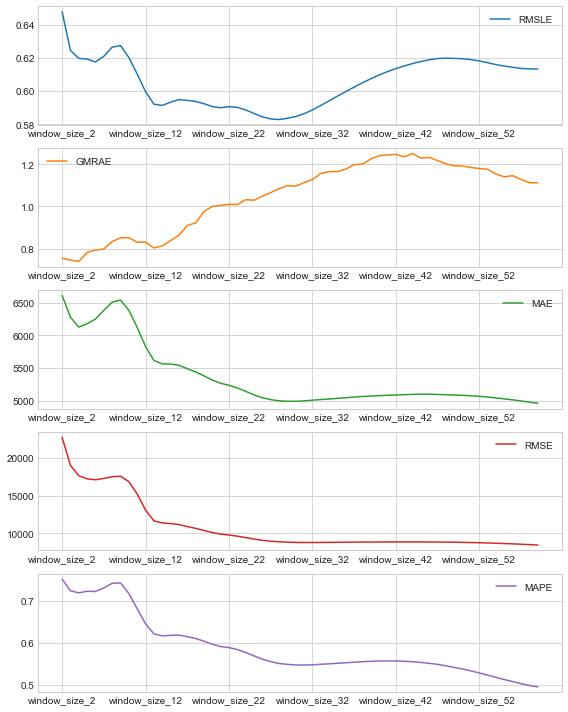

In [16]:
# metric evolution subplots
fig, ax = plt.subplots(5, figsize=(8, 10), tight_layout=True)
pd.DataFrame(eval_window_size).T.plot(ax=ax, subplots=True)
plt.show()

In conclusion:
- RMSLE increases drastically from window size 28 onwards. The MAE, RMSE and MAPE begin to flatten out around window size 28 and do not vary much after that point.
- The one with the best overall results is window of size 28. 

## Fit model with best window size

Once the window size that minimizes the error has been found, the successive SIR models are adjusted again.

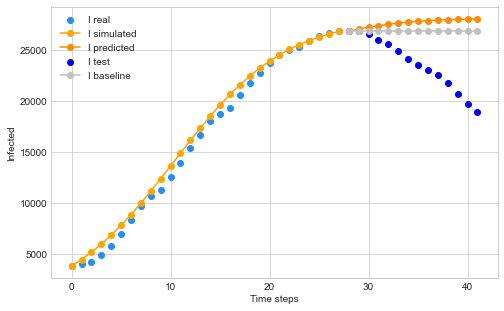

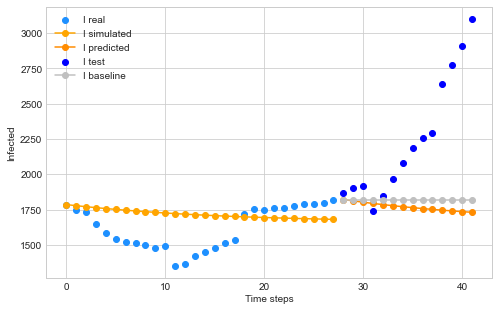

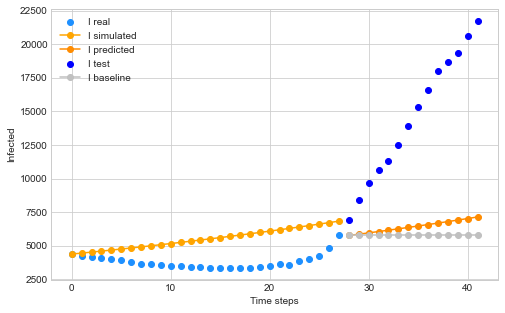

In [173]:
# create an object of the class
w_28_14 = WindowFit(window_size=28, steps_ahead=14, data=test_data, eval_mode='WF')
# get a random train and test window
window_train, window_test = w_28_14.random_windows()
# fit the model and get the predictions
S_simulated, I_simulated = w_28_14.fit_predict(window_train, return_only_predictions=True)
# fit model and plot the results for 3 random windows
w_28_14.plot_windows(max_subplots=3)

The overall performance of these models is evaluated and shown in tabular form by time horizon (SIR and baseline). 

In [48]:
# evaluate the model
e = w_28_14.evaluate()
# show the evaluation as DataFrame
pd.DataFrame(e)

,step_1,baseline_step_1,step_2,baseline_step_2,step_3,baseline_step_3,step_4,baseline_step_4,step_5,baseline_step_5,...,step_10,baseline_step_10,step_11,baseline_step_11,step_12,baseline_step_12,step_13,baseline_step_13,step_14,baseline_step_14
RMSLE,0.055910,0.055910,0.088375,0.107213,0.126012,0.157544,0.166329,0.207132,0.208580,0.255949,...,0.440217,0.491999,0.487197,0.535392,0.533548,0.576637,0.579667,0.616328,0.626368,0.655163
GMRAE,1.000000,NaN,0.754261,NaN,0.603580,NaN,0.624660,NaN,0.649033,NaN,...,0.774913,NaN,0.829878,NaN,0.853811,NaN,0.857258,NaN,0.860885,NaN
MAE,352.240000,352.240000,551.454478,702.126667,846.501240,1053.053333,1205.287128,1400.813333,1600.719458,1749.380000,...,4133.850489,3450.666667,4766.720955,3771.580000,5434.274607,4083.546667,6141.471285,4383.480000,6903.240474,4676.540000
RMSE,511.324737,511.324737,832.022681,1007.894065,1308.548887,1495.327148,1869.552415,1976.583821,2500.874226,2451.783380,...,6790.987706,4753.898179,7896.785313,5186.492089,9095.804022,5602.596514,10396.070122,6003.252702,11807.821404,6391.689804
MAPE,0.043207,0.043207,0.064516,0.084251,0.089538,0.124249,0.118642,0.163304,0.150481,0.202359,...,0.338979,0.398486,0.383017,0.437406,0.429094,0.476526,0.478046,0.515843,0.530822,0.555722


Now, these results are analyzed graphically. This facilitates and speeds up interpretation of the errors.

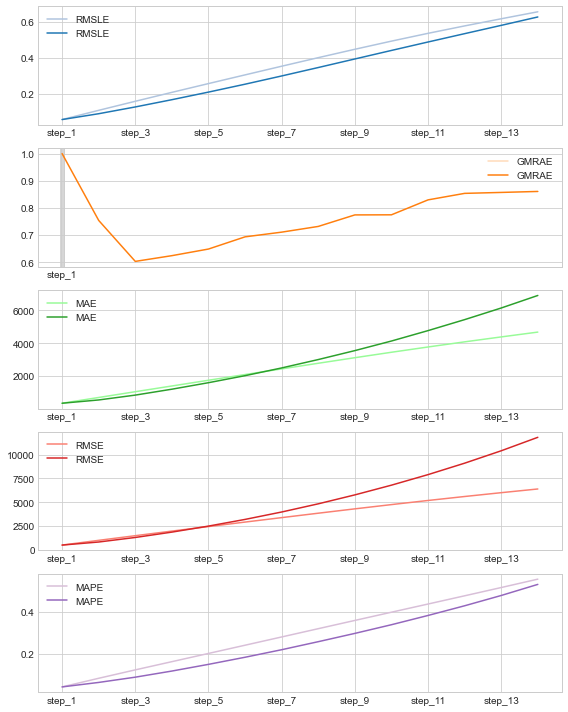

In [51]:
# metric evolution subplots
fig, ax = plt.subplots(5, figsize=(8, 10), tight_layout=True)
baseline_colors = ['lightsteelblue', 'peachpuff', 'palegreen', 'salmon', 'thistle']
pd.DataFrame(e).T.loc['baseline_step_1'::2,:].plot(ax=ax, subplots=True, color=baseline_colors)
pd.DataFrame(e).T.loc[::2,:].plot(ax=ax, subplots=True)
plt.show()

**Interpretation of the plot**
- The RMSLE and MAPE plots show that the SIR model outperforms the baseline; the opposite is true for MAE, RMSE. 
- All the graphs show an increase in error as the time horizon increases. This is to be expected, since uncertainty increases as the time horizon increases. 

## Forecasts exploration

The predictions generated are now explored to visually study the results. The predictions on the test set, which will be used to compare this model with other models, will be studied.

In [81]:
# define a window for test data
w_test = WindowFit(window_size=28, steps_ahead=14, data=test_data, eval_mode='WF')	
# get a dataframe with all predictions per step
y_fit = w_test.get_predictions_df(subset='test')

In [82]:
# same for train subset if necessary
w_train = WindowFit(window_size=28, steps_ahead=14, data=train_data, eval_mode='WF')	
y_fit = w_train.get_predictions_df(subset='train')

A sample of the first five sets of predictions are shown in the following table:

In [74]:
y_fit.head(5)

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,y_step_11,y_step_12,y_step_13,y_step_14
Date,,,,,,,,,,,,,,
2020-10-07,3374.0,3337.294046,3300.987283,3265.075372,3229.554017,3194.418977,3159.666056,3125.291103,3091.290010,3057.658713,3024.393191,2991.489467,2958.943606,2926.751719
2020-10-08,3409.0,3374.810031,3340.962835,3307.454979,3274.283058,3241.443710,3208.933606,3176.749447,3144.887969,3113.345938,3082.120152,3051.207442,3020.604670,2990.308731
2020-10-09,3460.0,3426.805419,3393.929169,3361.368202,3329.119493,3297.180051,3265.546915,3234.217151,3203.187852,3172.456137,3142.019155,3111.874080,3082.018113,3052.448484
2020-10-10,3610.0,3580.048588,3550.345561,3520.888860,3491.676443,3462.706288,3433.976387,3405.484751,3377.229405,3349.208392,3321.419768,3293.861609,3266.532004,3239.429059
2020-10-11,3596.0,3566.935963,3538.106708,3509.510341,3481.144980,3453.008762,3425.099839,3397.416377,3369.956556,3342.718572,3315.700634,3288.900964,3262.317803,3235.949401


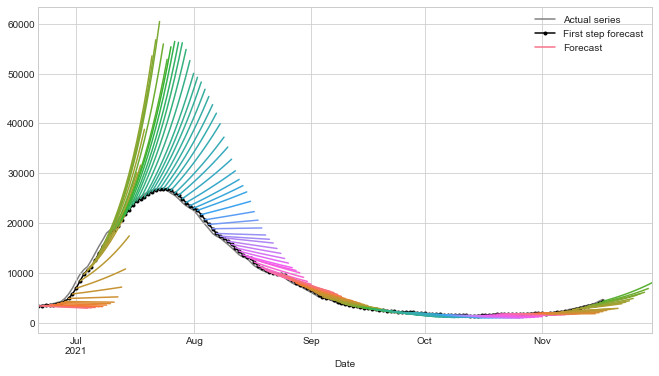

In [83]:
palette = dict(palette='husl', n_colors=64)
fig, ax1 = plt.subplots(1, 1, figsize=(11, 6))
ax1 = df['Infected'][y_fit.index].plot(color='grey', zorder=0, ax=ax1)
y_fit['y_step_1'].plot(ax=ax1, color='k', style='.-', legend='First Forecast')
plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Actual series', 'First step forecast', 'Forecast'])
plt.show()

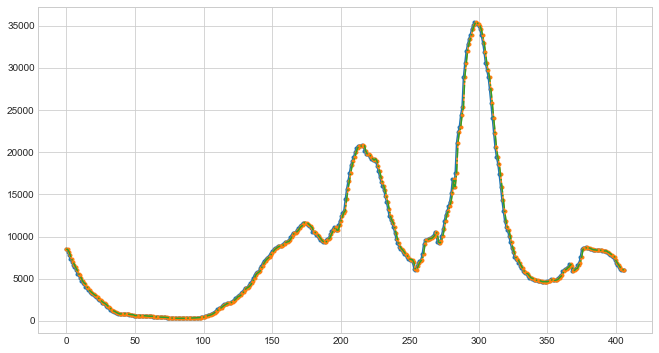

In [54]:
all = w_train.get_all_predictions(1)
base = w_train.baseline[1][:,0]
fig = plt.figure(figsize=(11, 6))

# plt.plot(df[-len(test_data[1]):]['Infected'][w_20_14.window_size+13:(len(y_fit)+w_20_14.window_size+13)].values, marker='.')
plt.plot(df[:len(train_data[1])]['Infected'][w_train.window_size:(len(y_fit)+w_train.window_size)].values, marker='.')
plt.plot(all, marker='.')
plt.plot(base, '-.')
plt.show()

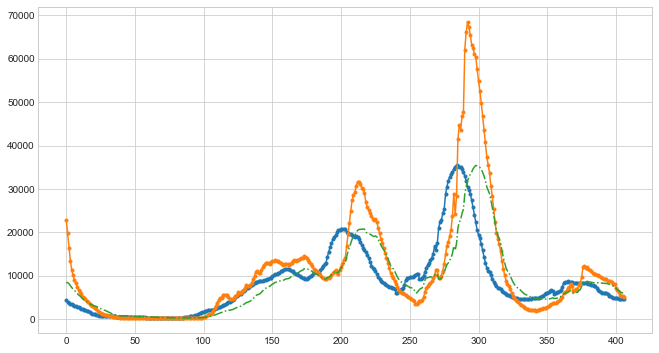

In [55]:
all = w_train.get_all_predictions(14)
base = w_train.baseline[1][:,-1]
fig = plt.figure(figsize=(11, 6))

# plt.plot(df[-len(test_data[1]):]['Infected'][w_20_14.window_size+13:(len(y_fit)+w_20_14.window_size+13)].values, marker='.')
plt.plot(df[:len(train_data[1])]['Infected'][w_train.window_size+13:(len(y_fit)+w_train.window_size+13)].values, marker='.')
plt.plot(all, marker='.')
plt.plot(base, '-.')
plt.show()

# Basic reproductive number $R_0$

In [36]:
w_r0 = WindowFit(window_size=28, steps_ahead=14, data=train_data, eval_mode='WF')
w_r0_pred = w_r0.get_all_predictions(horizon=1)	
w_r0_beta = w_r0.beta_series
w_r0_gamma = w_r0.gamma_series

In [39]:
for beta in w_r0_beta:
    if beta<0:
        print(beta)

-0.0004261196176464921
-0.009969048873807647
-0.018786015373253428
-0.027703754689705935
-0.038188401275228885
-0.04645065107462161
-0.05174862159352749
-0.061339827972331985
-0.07408021960575512
-0.08934553848585075
-0.1046785369903804
-0.1159911101472185
-0.12532930545530208
-0.13389776539083156
-0.1409768104628462
-0.14300439639479476
-0.14250948448076797
-0.14403477975280238
-0.1433274281691549
-0.14472459052373343
-0.14506615214506546
-0.14401695093048061
-0.14342291134442925
-0.14785347285150618
-0.14823388619267922
-0.14846494674810867
-0.1492215456486398
-0.15674271501528136
-0.1514361598022207
-0.1498083764671802
-0.14678844986257214
-0.14984700484923055
-0.1521150862067504
-0.15276223742834844
-0.14839514095956005
-0.15106770207496317
-0.13870645578454996
-0.1328473091158821
-0.12646105262942922
-0.11645695043303984
-0.10711151322879228
-0.10287581193966318
-0.09451757702687302
-0.09223235012416815
-0.08356715821720312
-0.07883094653701278
-0.0717632199570663
-0.0647469801466

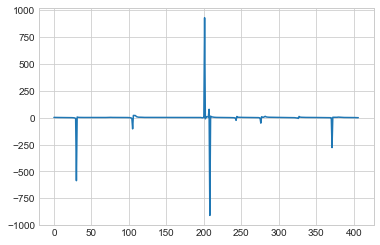

In [38]:
r0 = [beta/gamma for beta, gamma in zip(w_r0_beta, w_r0_gamma)]
plt.plot(r0)

In [29]:
434/(20+14)

12.764705882352942

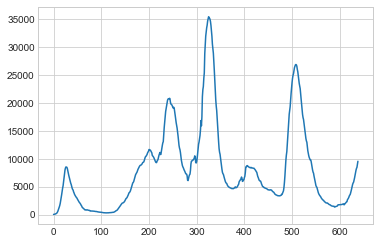

In [30]:
plt.plot(df['Infected'].values)

# Residuals exploration

If the model has succeeded in capturing all the information and structure of the available data, then the residuals should be random. That is, residuals are the part left that cannot be predicted. The exploration of these residuals provides a better understanding of the model and its scope. If the study suggests that the residuals are not random, i.e., that they follow some pattern or structure, then the model can be improved. 

The residual errors for a time step ahead (t+14) using the training subset of data are obtained below:

In [31]:
w_train = WindowFit(window_size=20, steps_ahead=14, data=train_data, eval_mode='WF')	
residuals = w_train.get_residuals(horizon=14) # residuals for the first time step (t+14)

First, errors are ploted over time. If the model was perfect, the resulting plot should be iid noise, showing the residuals distributed around zero (zero mean) with no pattern (trend, seasonal components, etc.). Then, the distribution of errors is studied via hisotograms and density plots.

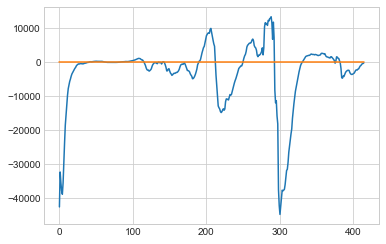

In [32]:
# line plot of the residuals
plt.plot(residuals)
plt.plot(np.zeros(residuals.shape))

Most residuals seem to be near to zero, although there are some extremely large errors. These values will cause the mean of the residuals to be a high negative number. In addition, these negative values mean that the model underpredicts: there are many more infected cases than expected by the model.

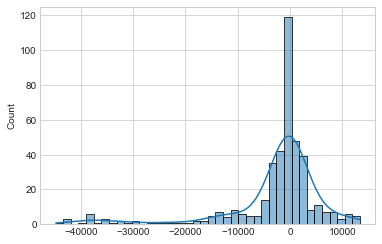

In [33]:
# histogram and density plot
sns.histplot(residuals, kde=True, bins=40)
plt.show()

Histogram and density plot of residuals showing heavy tail to the left representing the large errors mentioned before.

The code below evaluate which distribution fits better to the data and returns its parameters.

In [34]:
# def get_best_distribution(data):
#     dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
#     dist_results = []
#     params = {}
#     for dist_name in dist_names:
#         dist = getattr(st, dist_name)
#         param = dist.fit(data)

#         params[dist_name] = param
#         # Applying the Kolmogorov-Smirnov test
#         D, p = st.kstest(data, dist_name, args=param)
#         # print("p value for "+dist_name+" = "+str(p))
#         dist_results.append((dist_name, p))

#     # select the best fitted distribution
#     best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
#     # store the name of the best fit and its p value

#     print("Best fitting distribution: "+str(best_dist))
#     print("Best p value: "+ str(best_p))
#     print("Parameters for the best fit: "+ str(params[best_dist]))

#     return best_dist, best_p, params[best_dist]

# get_best_distribution(residuals)

Some statistics are now calculated to provide information on how the values are distributed around zero. If the model was perfect, then the mean would be zero; a negative mean represents a negative bias in the forecasts; a positive mean represents a positive bias.

In [35]:
from scipy.stats import kurtosis, skew

residuals_stats = pd.DataFrame(residuals).describe().T
residuals_stats['kurtosis'] = kurtosis(residuals) # excess kurtosis of normal distribution (if normal, kurtosis is zero)
residuals_stats['skewness'] = skew(residuals) # skewness of normal distribution (if normal, skewness is zero)
residuals_stats.T

,0
count,415.000000
mean,-2911.832504
std,9700.476279
min,-44841.428409
25%,-3278.133565
50%,-204.346445
75%,1092.772025
max,13394.324232
kurtosis,5.950213
skewness,-2.294489


- The mean is highly far from zero and negative (not even close to zero)
- Skewness is highly negative, i.e, the distribution of residuals exceeds that value from the overall shape of a normal distribution.
- Kurtosis is highly positive, i.e, the shape of the tails of the distribution of residuals exceeds that value from the shape of the tails of the normal distribution. The tails of this distribution are thicker than the normal dist.

Now the Q-Q plot is studied.

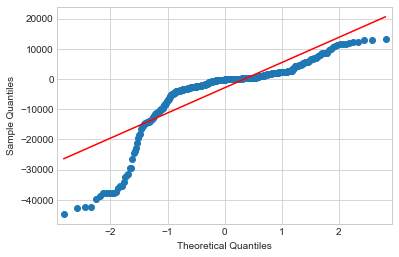

In [36]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='r')
plt.show()

The Q-Q plot confirms that residuals distribution is normal too peaked in zero, with heavy tails (left end of the Q-Q plot deviate from the diagonal) in comparison with a normal distribution. The distribution is more dispersed (higher std) than a normal distribution.

The autocorrelation plot shows the relation between a observation with prior observations in time. Ideally the residuals should not be correlated (scores between the dashed and dotes lines in the plot).

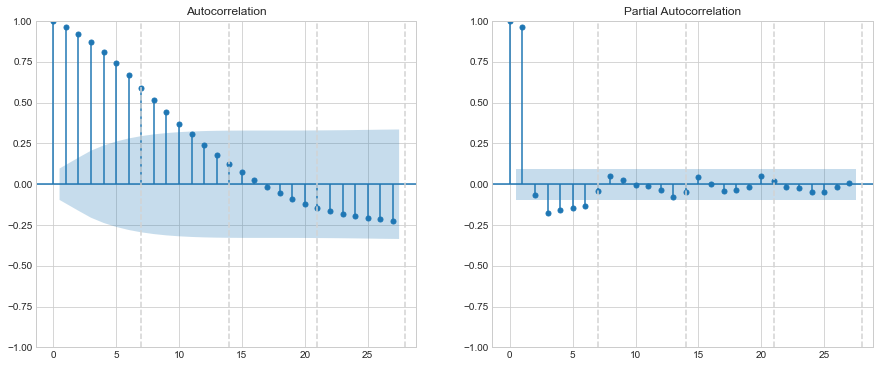

In [37]:
from pandas.plotting import autocorrelation_plot

plot_acf_pacf(residuals)
plt.show()

Since there exist significant autocorrelations in the plot, the model is missing information. The relationship between observations and lagged observations must be included in a model. 

Uncomment code below to study the residuals for different window sizes.

In [38]:
# def plot_residuals():
#     for window_size in range(2, 14):
#         print(f'Evaluating SIR for window size {window_size}...')
#         w = WindowFit(window_size, 1, data=[S, I, R], eval_mode='WF')
#         residuals = w.get_residuals(horizon=1)
#         #line plot
#         plt.plot(residuals)
#         plt.plot(np.zeros(residuals.shape))
#         plt.show()
#         # histogram and density plot
#         sns.histplot(residuals, kde=True, bins=40)
#         plt.show()
#         # qqplot
#         qqplot(residuals, line='r')
#         plt.show()
#         # autocorrelation plot
#         autocorrelation_plot(residuals)
#         plt.show()
#         # summary stats
#         residuals_stats = pd.DataFrame(residuals).describe().T
#         residuals_stats['kurtosis'] = kurtosis(residuals) # excess kurtosis of normal distribution (if normal, kurtosis is zero)
#         residuals_stats['skewness'] = skew(residuals) # skewness of normal distribution (if normal, skewness is zero)
#         display(residuals_stats.T)

# plot_residuals()

# Conclusion:
- The residuals obtained with this model are not normally distributed, indicating that SIR model has failed in explaining the behaviuor of the system. 